In [1]:
# default_exp synthetic_data

In [2]:
# hide
# export

import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.datasets import make_classification

In [3]:
# export

class DummyDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=100, n_cat_feats=2, n_cont_feats=2, n_targets=1, len_ts=24, n_dim=2):

        self.n_samples = n_samples
        if n_dim == 2:
            self.x_cat = torch.ones(n_samples, n_cat_feats)
            self.x_cont = torch.ones(n_samples, n_cont_feats)
            self.y = torch.ones(n_samples, n_targets)
        elif n_dim == 3:
            self.x_cat = torch.ones(n_samples, n_cat_feats, len_ts)
            self.x_cont = torch.ones(n_samples, n_cont_feats, len_ts)
            self.y = torch.ones(n_samples, n_targets, len_ts)
        elif n_dim == 4:
            self.x_cat = torch.ones(n_samples, n_cat_feats, len_ts, len_ts)
            self.x_cont = torch.ones(n_samples, n_cont_feats, len_ts, len_ts)
            self.y = torch.ones(n_samples, n_targets, len_ts, len_ts)

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        x_cat = self.x_cat[idx, :]
        x_cont = self.x_cont[idx, :]
        y = self.y[idx, :]
        return x_cat, x_cont, y

In [4]:
# hide

n_dim = 2
data = DummyDataset(n_dim=n_dim)
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    assert(x_cat.dim()==x_cont.dim()==n_dim)

n_dim = 3
data = DummyDataset(n_dim=n_dim)
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    assert(x_cat.dim()==x_cont.dim()==n_dim)

n_dim = 4
data = DummyDataset(n_dim=n_dim)
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    assert(x_cat.dim()==x_cont.dim()==n_dim)

In [5]:
# export

class GaussianDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=1000, n_classes=2):
        self.n_samples = n_samples
        self.n_classes = n_classes
        self.x_cat = torch.zeros(self.n_samples*self.n_classes, 1)
        self.x_cont = torch.zeros(self.n_samples*self.n_classes, 1)
        self.y = torch.zeros(self.n_samples*self.n_classes, 1)
        self.means = torch.linspace(0, n_classes, n_classes)
        self.scales = torch.linspace(1, 1/n_classes, n_classes)
        
        self.generate_series()
        self.x_cont = (self.x_cont-self.x_cont.min())/(self.x_cont.max()-self.x_cont.min())
        
    def generate_series(self):
        for c in range(self.n_classes):
            for idx in range(self.n_samples):
                self.x_cat[c*self.n_samples + idx] = c+1
                self.y[c*self.n_samples + idx] = c
                self.x_cont[c*self.n_samples + idx] = torch.distributions.Normal(self.means[c], self.scales[c]).rsample()
        
    def __len__(self):
            return self.n_samples*self.n_classes

    def __getitem__(self, idx):
        x_cat = self.x_cat[idx, :]
        x_cont = self.x_cont[idx, :]
        y = self.y[idx, :]
        return x_cat, x_cont, y

In [6]:
# hide

n_samples = 1000
n_classes = 4
batch_size = 512

data = GaussianDataset(n_samples=n_samples, n_classes=n_classes)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    #print(x_cat.shape, x_cont.shape, y.shape)
    break

In [7]:
# export

def plot_class_hists(x_cat, x_cont):
    plt.figure()
    for c in x_cat.unique():
        x_plot = x_cont[x_cat==c]
        plt.hist(x_plot.reshape(1, -1), alpha=0.75, label=f'{int(c)}')
    plt.xlim(0, 1)
    plt.legend()
    plt.show()
    return

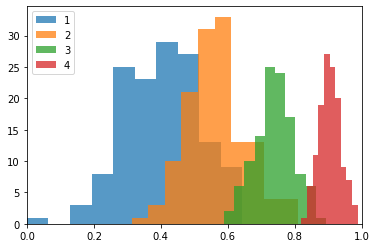

In [8]:
# hide

plot_class_hists(x_cat, x_cont)

In [9]:
# export

class ClassificationDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=1000, n_features=8, n_classes=4):
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_classes = n_classes
        self.make_dataset()
        
    def make_dataset(self):
        x, y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=self.n_classes, n_informative=self.n_features, n_redundant=0)
        self.x_cat = torch.tensor(y.reshape(-1, 1) + 1).float()
        self.x_cont = torch.tensor(x).float()
        self.x_cont = self.scale(self.x_cont)
        self.y = torch.tensor(y.reshape(-1, 1)).float()
        return
    
    def scale(self, x):
        return (x - x.min())/(x.max()-x.min())
        
    def __len__(self):
            return self.n_samples

    def __getitem__(self, idx):
        x_cat = self.x_cat[idx, :]
        x_cont = self.x_cont[idx, :]
        y = self.y[idx, :]
        return x_cat, x_cont, y

In [10]:
# hide

data = ClassificationDataset()
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    print(x_cat.shape, x_cont.shape, y.shape)
    break

torch.Size([32, 1]) torch.Size([32, 8]) torch.Size([32, 1])


In [11]:
# export

torch.pi = 3.141592653589793

class SineDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=1000, n_classes=2, n_features=1, len_ts=24, noise=0.05, n_dim=2):
        self.n_samples = n_samples
        self.n_classes = n_classes
        self.n_features = n_features
        self.len_ts = len_ts
        self.amp_min = 0.25
        self.amp_max = 0.75
        self.freq_min = 1.0
        self.freq_max = 3.0
        self.phase_min = 0.0
        self.phase_max = 2.0*torch.pi
        self.noise = noise
        self.cat_data = torch.zeros(self.n_samples*self.n_classes, 1, self.len_ts)
        self.cont_data = torch.zeros(self.n_samples*self.n_classes, self.n_features, self.len_ts)
        self.target = torch.zeros(self.n_samples*self.n_classes, 1, self.len_ts)
        self.n_dim = n_dim
        
        self.generate_series()
        self.cont_data = (self.cont_data-self.cont_data.min())/(self.cont_data.max()-self.cont_data.min())
        if self.n_dim==2:
            self.reshape_2d()
        
    def generate_series(self):
        for c in range(self.n_classes):
            t = torch.linspace(0, 1, self.len_ts)
            amplitudes = torch.linspace(self.amp_min, self.amp_max, self.n_classes)
            frequencies = torch.linspace(self.freq_min, self.freq_max, self.n_classes)
            phases = torch.linspace(self.phase_min, self.phase_max, self.n_classes)
            for idx in range(self.n_samples):
                self.cat_data[c*self.n_samples + idx, :, :] = c+1
                self.target[c*self.n_samples + idx, :, :] = c
                for f_idx in range(self.n_features):
                    a = torch.ones_like(t)*amplitudes[c]
                    f = torch.ones_like(t)*frequencies[c]
                    p = torch.ones_like(t)*phases[c]
                    self.cont_data[c*self.n_samples + idx, f_idx, :] = a*torch.sin(2*torch.pi*f*t + p) + self.noise*torch.randn_like(t)
                    
    def reshape_2d(self):
        #todo: check if this works with n_features > 1
        self.cat_data = self.cat_data.reshape(self.n_samples*self.n_classes*self.len_ts, 1)
        self.cont_data = self.cont_data.reshape(self.n_samples*self.n_classes*self.len_ts, self.n_features)
        self.target = self.target.reshape(self.n_samples*self.n_classes*self.len_ts, 1)
        
    def __len__(self):
        if self.n_dim==2:
            return self.n_samples*self.n_classes*self.len_ts
        else:
            return self.n_samples*self.n_classes

    def __getitem__(self, idx):
        x_cat = self.cat_data[idx, :]
        x_cont = self.cont_data[idx, :]
        y = self.target[idx, :]
        return x_cat, x_cont, y

In [12]:
# hide

n_samples = 100
n_classes = 4
n_features = 1
len_ts = 24
batch_size = 32
n_dim = 3

data = SineDataset(n_samples=n_samples, n_classes=n_classes, n_features=n_features, len_ts=len_ts, n_dim=n_dim)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    assert(x_cat.min() == 1 and x_cat.max() == n_classes)
    assert(x_cont.max() <= 1 and x_cont.min() >= 0)
    if n_dim==2:
        assert(x_cat.shape == (batch_size, 1))
        assert(x_cont.shape) == (batch_size, n_features)
        assert(y.shape == (batch_size, 1))
    if n_dim==3:
        assert(x_cat.shape == (batch_size, 1, len_ts))
        assert(x_cont.shape) == (batch_size, n_features, len_ts)
        assert(y.shape == (batch_size, 1, len_ts))

In [13]:
# export

def plot_sine_samples(dl):
    plt.figure(figsize=(16, 9))
    for _, x_cont, _ in dl:
        for idx in range(x_cont.shape[0]):
            plt.plot(x_cont[idx, 0, :])
    plt.show()

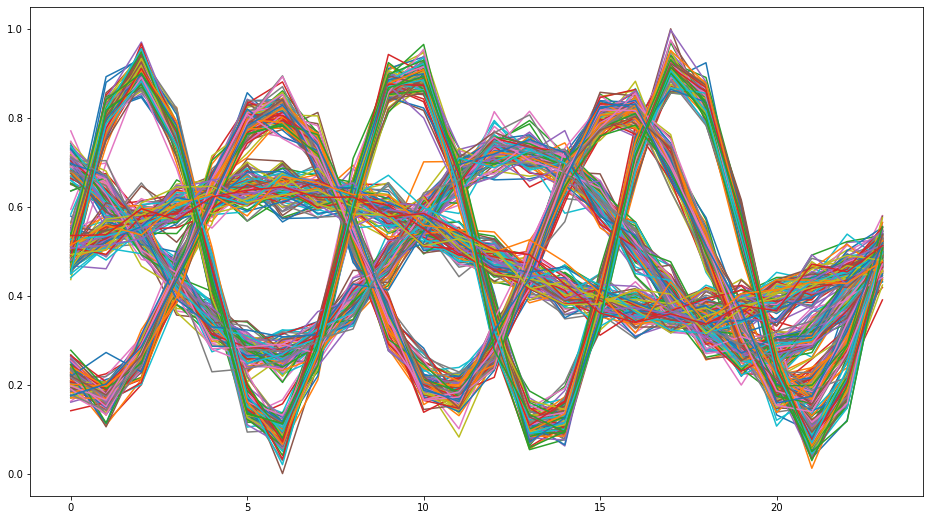

In [14]:
# hide

plot_sine_samples(dl)